# Introduction to Data Analysis

# What is Data Analysis?

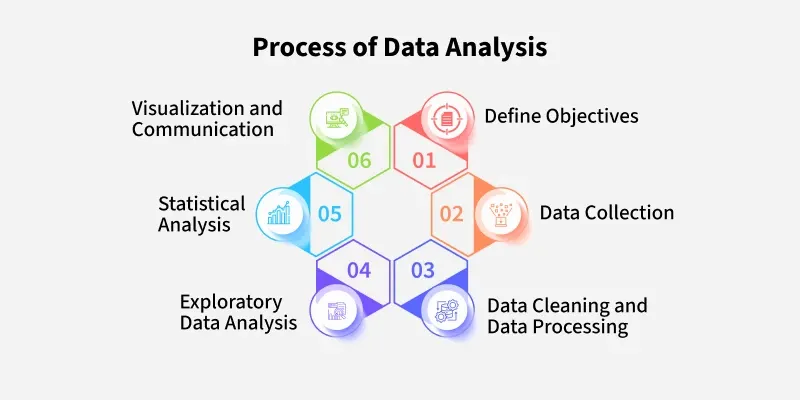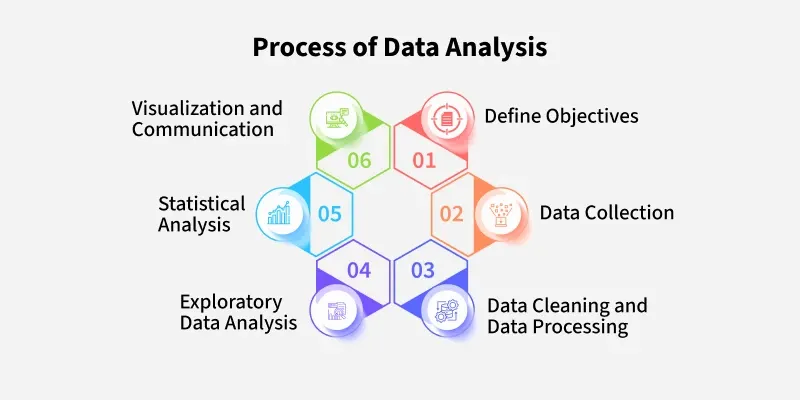

# Pandas Recap

In [1]:
import pandas as pd
df = pd.read_csv("expenses.csv")
print(df.head())

         Date       Category  Amount           Description
0  2025-08-01           Food    15.5         Lunch at cafe
1  2025-08-02      Transport     7.2              Bus fare
2  2025-08-03  Entertainment    25.0          Movie ticket
3  2025-08-04           Food    12.0  Dinner at restaurant
4  2025-08-05      Utilities    45.0      Electricity bill


# Summarizing Data

In [2]:
print(df.describe())
print(df["Amount"].mean())  # average
print(df["Amount"].median())  # middle value
print(df["Amount"].std())  # spread

          Amount
count   5.000000
mean   20.940000
std    14.947174
min     7.200000
25%    12.000000
50%    15.500000
75%    25.000000
max    45.000000
20.94
15.5
14.947173645877003


# Sorting & Filtering

In [3]:
# Filter high expenses
high_expenses = df[df["Amount"] > 20]

# Sort by amount
sorted_df = df.sort_values("Amount", ascending=False)

# Counting Categories

In [4]:
print(df["Category"].value_counts())

Category
Food             2
Transport        1
Entertainment    1
Utilities        1
Name: count, dtype: int64


# Grouping Data

In [5]:
category_totals = df.groupby("Category")["Amount"].sum()
print(category_totals)

Category
Entertainment    25.0
Food             27.5
Transport         7.2
Utilities        45.0
Name: Amount, dtype: float64


# Correlations

In [6]:
print(df.corr(numeric_only=True))

        Amount
Amount     1.0


Shows relationships between numeric columns.

##  Data Analysis Examples

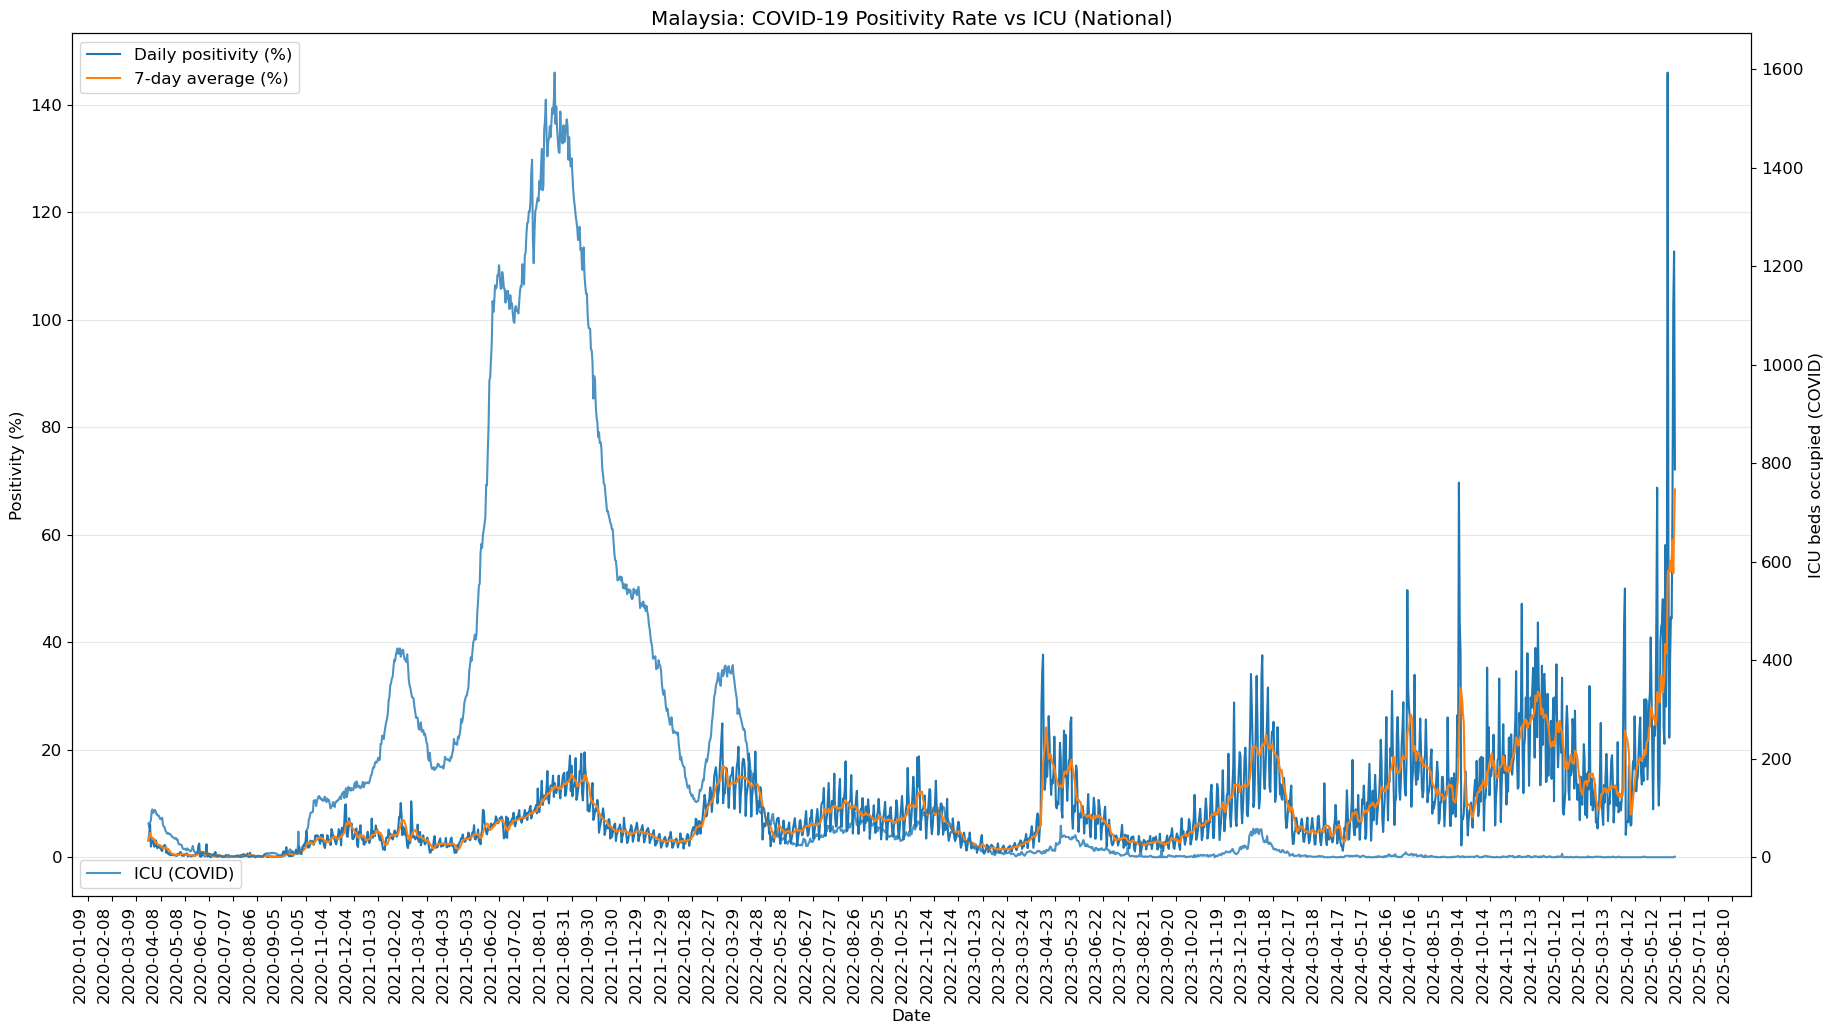

Tidy CSV saved to: C:\Users\Woon\Documents\sciemntificcomputingfornonscientist\positivity_vs_icu_malaysia.csv
Figure saved to: C:\Users\Woon\Documents\sciemntificcomputingfornonscientist\positivity_vs_icu_malaysia.png


In [5]:
# -*- coding: utf-8 -*-
"""
Malaysia COVID-19: Positivity Rate vs ICU Occupancy (Daily + 7D Avg)
Notebook-friendly version (no SystemExit).
"""

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# -------- Config --------
URL_TESTS = "https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/tests_malaysia.csv"
URL_CASES = "https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_malaysia.csv"
URL_ICU   = "https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/icu.csv"

CACHE_DIR = Path(".")
OUT_CSV   = CACHE_DIR / "positivity_vs_icu_malaysia.csv"
OUT_PNG   = CACHE_DIR / "positivity_vs_icu_malaysia.png"

# -------- Helpers --------
def read_csv_strip(url_or_path, **kwargs) -> pd.DataFrame:
    df = pd.read_csv(url_or_path, **kwargs)
    df.columns = df.columns.str.strip()
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
    return df

def require_columns(df: pd.DataFrame, cols, name: str = "DataFrame") -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{name}: missing expected columns: {missing}\nAvailable: {df.columns.tolist()}")

def safe_divide(numer: pd.Series, denom: pd.Series) -> pd.Series:
    denom_nz = denom.where(denom > 0)
    return numer.where(denom_nz.notna()) / denom_nz

# -------- Main --------
def main():
    # Load
    tests = read_csv_strip(URL_TESTS)
    cases = read_csv_strip(URL_CASES)
    icu   = read_csv_strip(URL_ICU)

    # Validate
    require_columns(tests, ["date", "pcr", "rtk-ag"], "tests_malaysia")
    require_columns(cases, ["date", "cases_new"], "cases_malaysia")
    require_columns(icu,   ["date", "state", "icu_covid"], "icu")

    # ICU: state-level -> national by date
    icu_nat = icu.groupby("date", as_index=False)["icu_covid"].sum()

    # Total tests and merge
    tests["tests_total"] = tests["pcr"].fillna(0) + tests["rtk-ag"].fillna(0)
    merged = (
        cases[["date", "cases_new"]]
        .merge(tests[["date", "tests_total"]], on="date", how="inner")
        .merge(icu_nat, on="date", how="inner")
        .sort_values("date")
        .reset_index(drop=True)
    )

    # Positivity
    merged["positivity_rate"] = safe_divide(merged["cases_new"], merged["tests_total"])
    merged["positivity_rate_7d"] = merged["positivity_rate"].rolling(window=7, min_periods=1).mean()

    # Save tidy data
    merged.to_csv(OUT_CSV, index=False)

    # Plot
    plt.rcParams.update({"font.size": 12})
    fig, ax = plt.subplots(figsize=(18.5, 10.5))
    fig.autofmt_xdate(rotation=90)

    ax.plot(merged["date"], merged["positivity_rate"] * 100, label="Daily positivity (%)")
    ax.plot(merged["date"], merged["positivity_rate_7d"] * 100, label="7-day average (%)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Positivity (%)")
    ax.set_title("Malaysia: COVID-19 Positivity Rate vs ICU (National)")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend()

    ax2 = ax.twinx()
    ax2.plot(merged["date"], merged["icu_covid"], label="ICU (COVID)", alpha=0.8)
    ax2.set_ylabel("ICU beds occupied (COVID)")
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(30))
    ax2.legend(loc="lower left")

    plt.tight_layout()
    plt.savefig(OUT_PNG, dpi=150, bbox_inches="tight")
    plt.show()

    print(f"Tidy CSV saved to: {OUT_CSV.resolve()}")
    print(f"Figure saved to: {OUT_PNG.resolve()}")

# Run directly in notebook
main()


# In-Class Activity

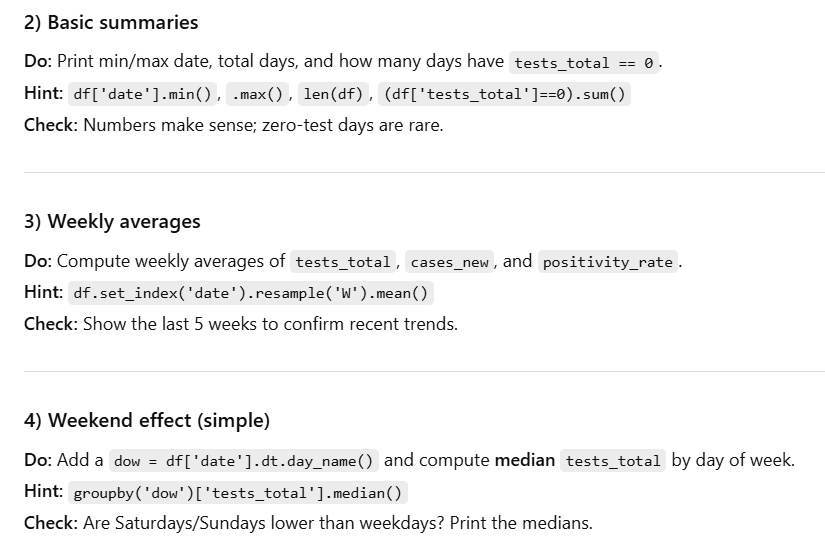

## In-calss activity